### Drop columns that contain 50% or more negatives.
### Drop rows that contain any negatives or zeros.

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('Data/macro_features_and_real_oil_prices_log_tranferred_dropped_Nan_skipped_neg_and_zeros_for_log.csv', skiprows=1)
# Drop the "0" column (unnecessary index column)
df = df.drop(columns=['0'])

# 1. Drop columns that contain 50% or more negatives, excluding the first column (index)
cols_to_drop = [col for col in df.columns[1:] if df[col].dtype in ['float64', 'int64'] and (df[col] < 0).mean() >= 0.5]
df = df.drop(columns=cols_to_drop)

# 2. Drop rows that contain any negatives or zeros, excluding the first column
rows_with_neg_or_zero = df[(df[df.columns[1:]].select_dtypes(['float64', 'int64']) <= 0).any(axis=1)].index
df = df.drop(index=rows_with_neg_or_zero)

# Convert the date column to a datetime format
df['date'] = pd.to_datetime(df['date'])

# Create separate columns for year, month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Now, drop the original date column
df = df.drop(columns=['date'])

# See if I'm doing this right
df.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,Real Oil Prices,year,month
0,12.962951,12.750812,5.803950,19.534471,17.325209,5.952564,6.137924,6.101171,6.327298,5.854031,...,3.772941,3.498251,6.104337,15.967271,17.533756,9.539485,4.091742,13.715729,1992,2
1,12.965336,12.751983,5.806582,19.540266,17.320880,5.964607,6.150103,6.113980,6.340179,5.883401,...,3.782409,3.500802,6.247928,15.942881,17.542367,9.549875,4.019942,13.601725,1992,3
2,12.970718,12.755952,5.807793,19.549848,17.329560,5.975704,6.160908,6.124948,6.353748,5.910003,...,3.783457,3.505891,6.270529,15.972082,17.542547,9.562213,4.016897,14.512195,1992,4
3,12.978406,12.763876,5.815217,19.537241,17.337448,5.980389,6.168790,6.133329,6.363083,5.954359,...,3.783457,3.509696,6.307429,15.924905,17.543025,9.580477,3.880490,15.017895,1992,5
4,12.984426,12.770292,5.819106,19.552370,17.341493,5.981250,6.165329,6.128931,6.356100,5.934182,...,3.794936,3.512227,6.329124,15.943545,17.556218,9.597480,3.882946,15.981442,1992,6


In [2]:
# Save the cleaned dataset
df.to_csv('Data/cleaned_dataset.csv', index=False)

### Random Forest

#### 1. Splitting Data into Train and Test Sets

In [3]:
from sklearn.model_selection import train_test_split

# 'Real Oil Prices' is the target column
X = df.drop('Real Oil Prices', axis=1)
y = df['Real Oil Prices']

# Split the data into training and testing sets
# 80% of the data will be used for training, 20% for testing (0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 2. Creating and Training the Random Forest Regressor

In [4]:
from sklearn.ensemble import RandomForestRegressor

# Create the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

#### 3. Making Predictions and Evaluating the Model

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Mean Absolute Error: 1.0493011571662254
Mean Squared Error: 1.8172735518378331


#### 4. Feature Importance

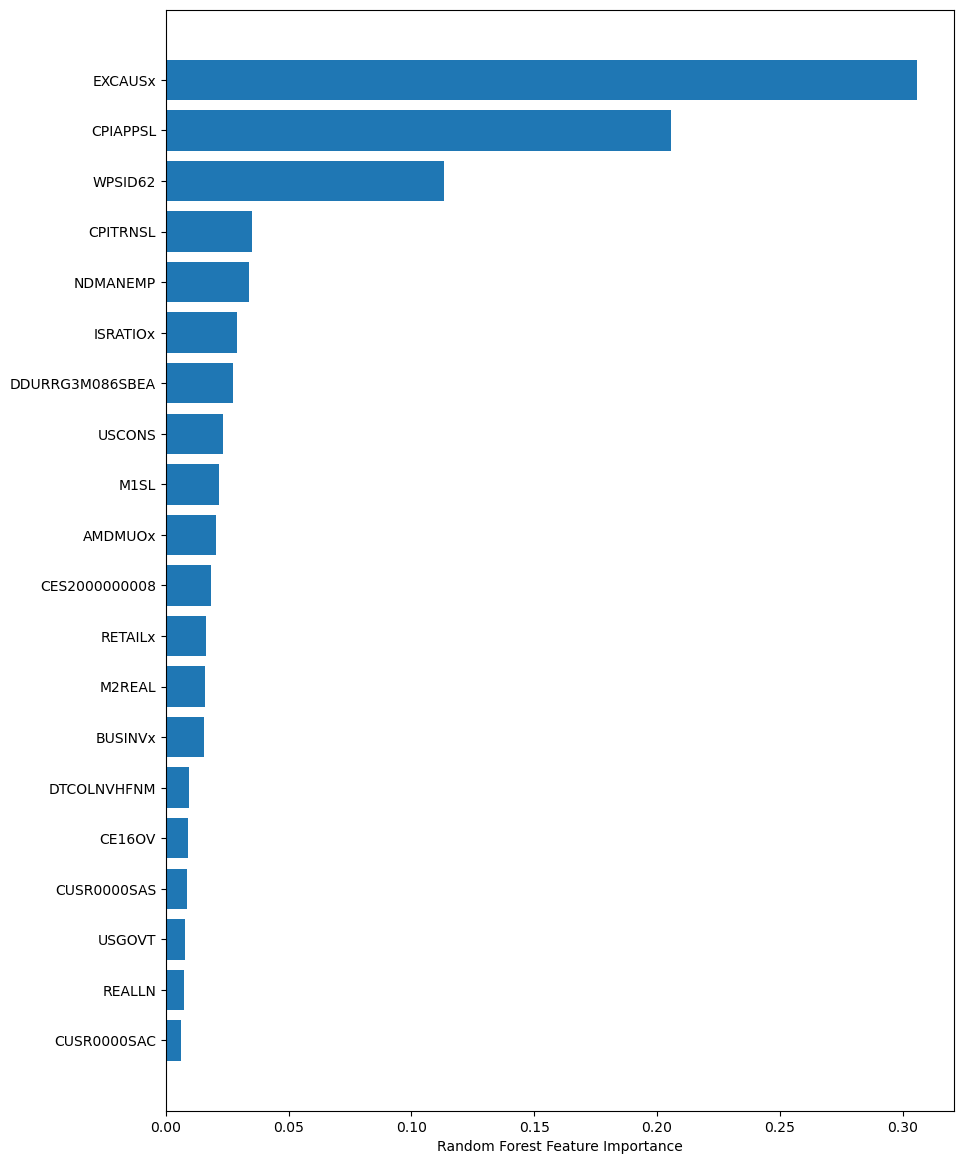

In [6]:
importances = model.feature_importances_
features = X.columns

# Sorting feature importances
sorted_idx = importances.argsort()

# Selecting top 20
top_20_idx = sorted_idx[-20:]

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 12))
plt.barh(range(20), importances[top_20_idx])
plt.yticks(range(20), features[top_20_idx], fontsize=10) 
plt.xlabel("Random Forest Feature Importance")
plt.tight_layout(pad=2) 
plt.show()

### Learning Curve Attempt

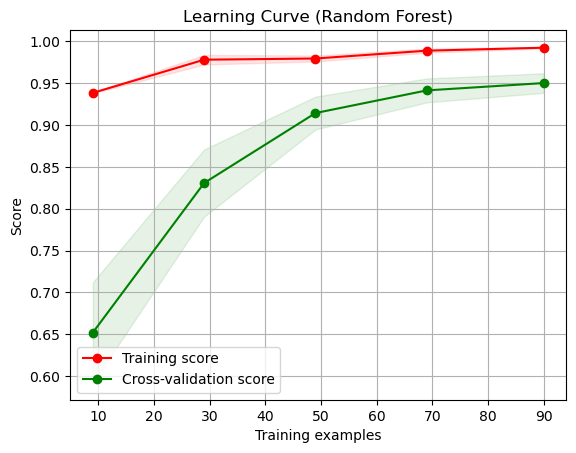

In [7]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

plot_learning_curve(model, "Learning Curve (Random Forest)", X_train, y_train, cv=5)
plt.show()

## Actual Vs. Predicted

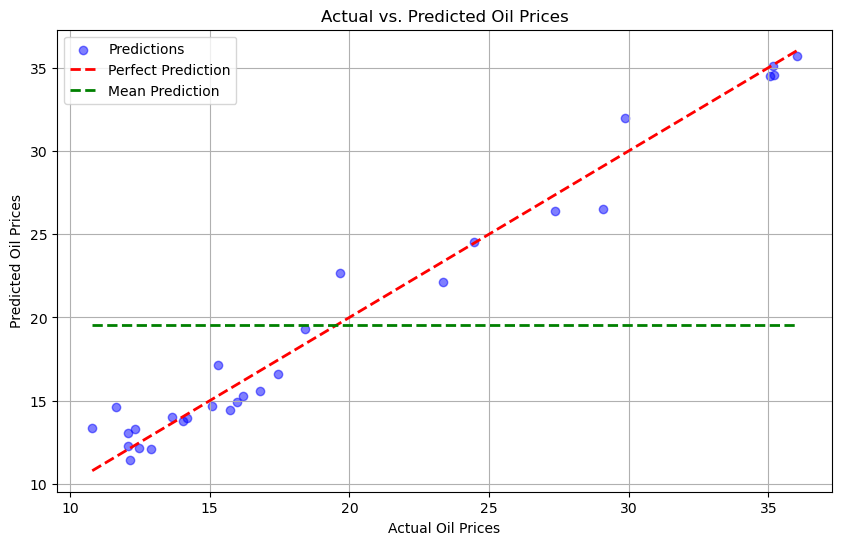

In [8]:
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5, label='Predictions', color='blue')

# Perfect Prediction line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', lw=2, color='red', label='Perfect Prediction')

# Mean Prediction line
plt.plot([y_test.min(), y_test.max()], [predictions.mean(), predictions.mean()], '--', lw=2, color='green', label='Mean Prediction')

plt.xlabel('Actual Oil Prices')
plt.ylabel('Predicted Oil Prices')
plt.title('Actual vs. Predicted Oil Prices')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()